<a href="https://colab.research.google.com/github/THECODEDEMOGORGON/TS_DL_workshop/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт необходимых модулей:

In [1]:
import warnings

# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import datetime

# second part
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy import stats

import statsmodels.tsa.api as ts
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import statsmodels as sm
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR


import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


Для считывания данных нам нужно подключить google drive, запустите ячейку ниже и следуйте инструкциям:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Считываем данные:

In [3]:
%%time
df = pd.read_csv('/content/drive/MyDrive/ts_dl_workshop/full_data_sum.csv')
df['date'] = pd.to_datetime(df['date'])
df['dt'] = pd.to_datetime(df.date) + df.hour.astype('timedelta64[h]')

CPU times: user 6.58 s, sys: 503 ms, total: 7.08 s
Wall time: 12.1 s


Проверим, что в них нет пропусков:

In [4]:
series = ['internet', 'sms_in', 'sms_out', 'call_in', 'call_out']
nans = df[series].isna().sum()
nans

internet    0
sms_in      0
sms_out     0
call_in     0
call_out    0
dtype: int64

### Визуализация и анализ разных временных рядов

Напишем функцию для визуализации и анализа данных, связанных с определенным столбцом в исходном DataFrame.
Она включает в себя:
- стандартизацию данных (если необходимо)
- создание нескольких графиков, отображающих распределение значений показателя
- пример изменения показателя на одной БС
- изменение среднего значения показателя по всем станциям за все время
- автокорреляционную функцию показателя
- частную автокорреляционную функцию показателя


In [5]:
def standardize_group(series):
    """
    Стандартизация значений в группе.

    Параметры:
    - series (pandas.Series): Входной столбец данных.

    Возвращает:
    - pandas.Series: Стандартизированные значения входного столбца данных.
    """
    return (series - series.mean()) / series.std()

def vis_col(input_data: pd.DataFrame,
            col: str,
            scaled=False):
    """
    Визуализация данных для определенного столбца в DataFrame.

    Параметры:
    - input_data (pd.DataFrame): Исходные данные в виде DataFrame.
    - col (str): Название столбца данных, который нужно визуализировать.
    - scaled (bool, optional): Флаг для стандартизации значений столбца. По умолчанию False.

    Возвращает:
    - None: Ничего не возвращает, но рисует графики для визуализации данных.

    Пример использования:
    vis_col(data_frame, 'column_name', scaled=True)
    """

    df_ = input_data.copy()

    # Стандартизация значений колонки, если флаг установлен
    if scaled:
        df_[col] = df_.groupby('square_id')[col].transform(standardize_group)

    # Инициализация подграфиков
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(30,15))
    ax1 = axs[0, 0]  # График 1
    ax2 = axs[0, 1]  # График 2
    gs = axs[0, 1].get_gridspec()
    axs[1, 0].remove()
    axs[1, 1].remove()
    axs[0, 2].remove()
    axs[0, 3].remove()
    axs[1, 2].remove()
    axs[1, 3].remove()
    ax3 = fig.add_subplot(gs[1, 0:2])  # График 3
    ax4 = fig.add_subplot(gs[0:1, 2:4])  # График 4 (АКФ)
    ax5 = fig.add_subplot(gs[1, 2:4])  # График 5 (Частная АКФ)

    example = df_[df_.square_id==1150].set_index('date')[col]

    # Усредненное значение интернет-нагрузки за каждый час
    _agg = df_.groupby(['date', 'hour'])[col].mean()
    _agg = _agg.reset_index().set_index('date')[col]

    # График 1: Распределение значений столбца
    sns.histplot(df_[col], bins=100, ax=ax1).set(title=f'Распределение значений {col}');

    # График 2: Пример изменения столбца на одной станции
    sns.lineplot(x=example.index,
                 y=example.values,
                 errorbar='ci',
                 err_style='band', ax=ax2).set(title=f'Пример изменения {col} на одной станции');
    ax2.tick_params(axis='x', rotation=45)

    # График 3: Изменение среднего значения столбца за исследуемый период
    sns.lineplot(data=_agg,
                 errorbar='ci',
                 err_style='band', ax=ax3).set(title=f'Изменение среднего значения {col} за исследуемый период');
    ax3.tick_params(axis='x', rotation=45)

    # График 4: Автокорреляционная функция (АКФ) столбца
    nlags = 24 * 7
    corrs, ccnf_intervals = ts.acf(_agg, nlags=nlags, alpha=.05)
    sns.barplot(x=np.arange(0,nlags+1), y=corrs, ax=ax4).set(title=f'АКФ признака {col} за периоды от 1 до {nlags} часов');
    ax4.xaxis.set_ticks(np.arange(0, nlags+1, 10))
    ax4.tick_params(axis='x', rotation=45)

    # График 5: Частная автокорреляционная функция (Частная АКФ) столбца
    nlags = 72
    corrs, ccnf_intervals = ts.pacf(_agg, nlags=nlags, alpha=.05)
    sns.barplot(x=np.arange(0,nlags+1), y=corrs, ax=ax5).set(title=f'Частная АКФ признака {col} за периоды от 1 до {nlags} часов');
    ax5.xaxis.set_ticks(np.arange(0, nlags+1, 10))
    ax5.tick_params(axis='x', rotation=45)


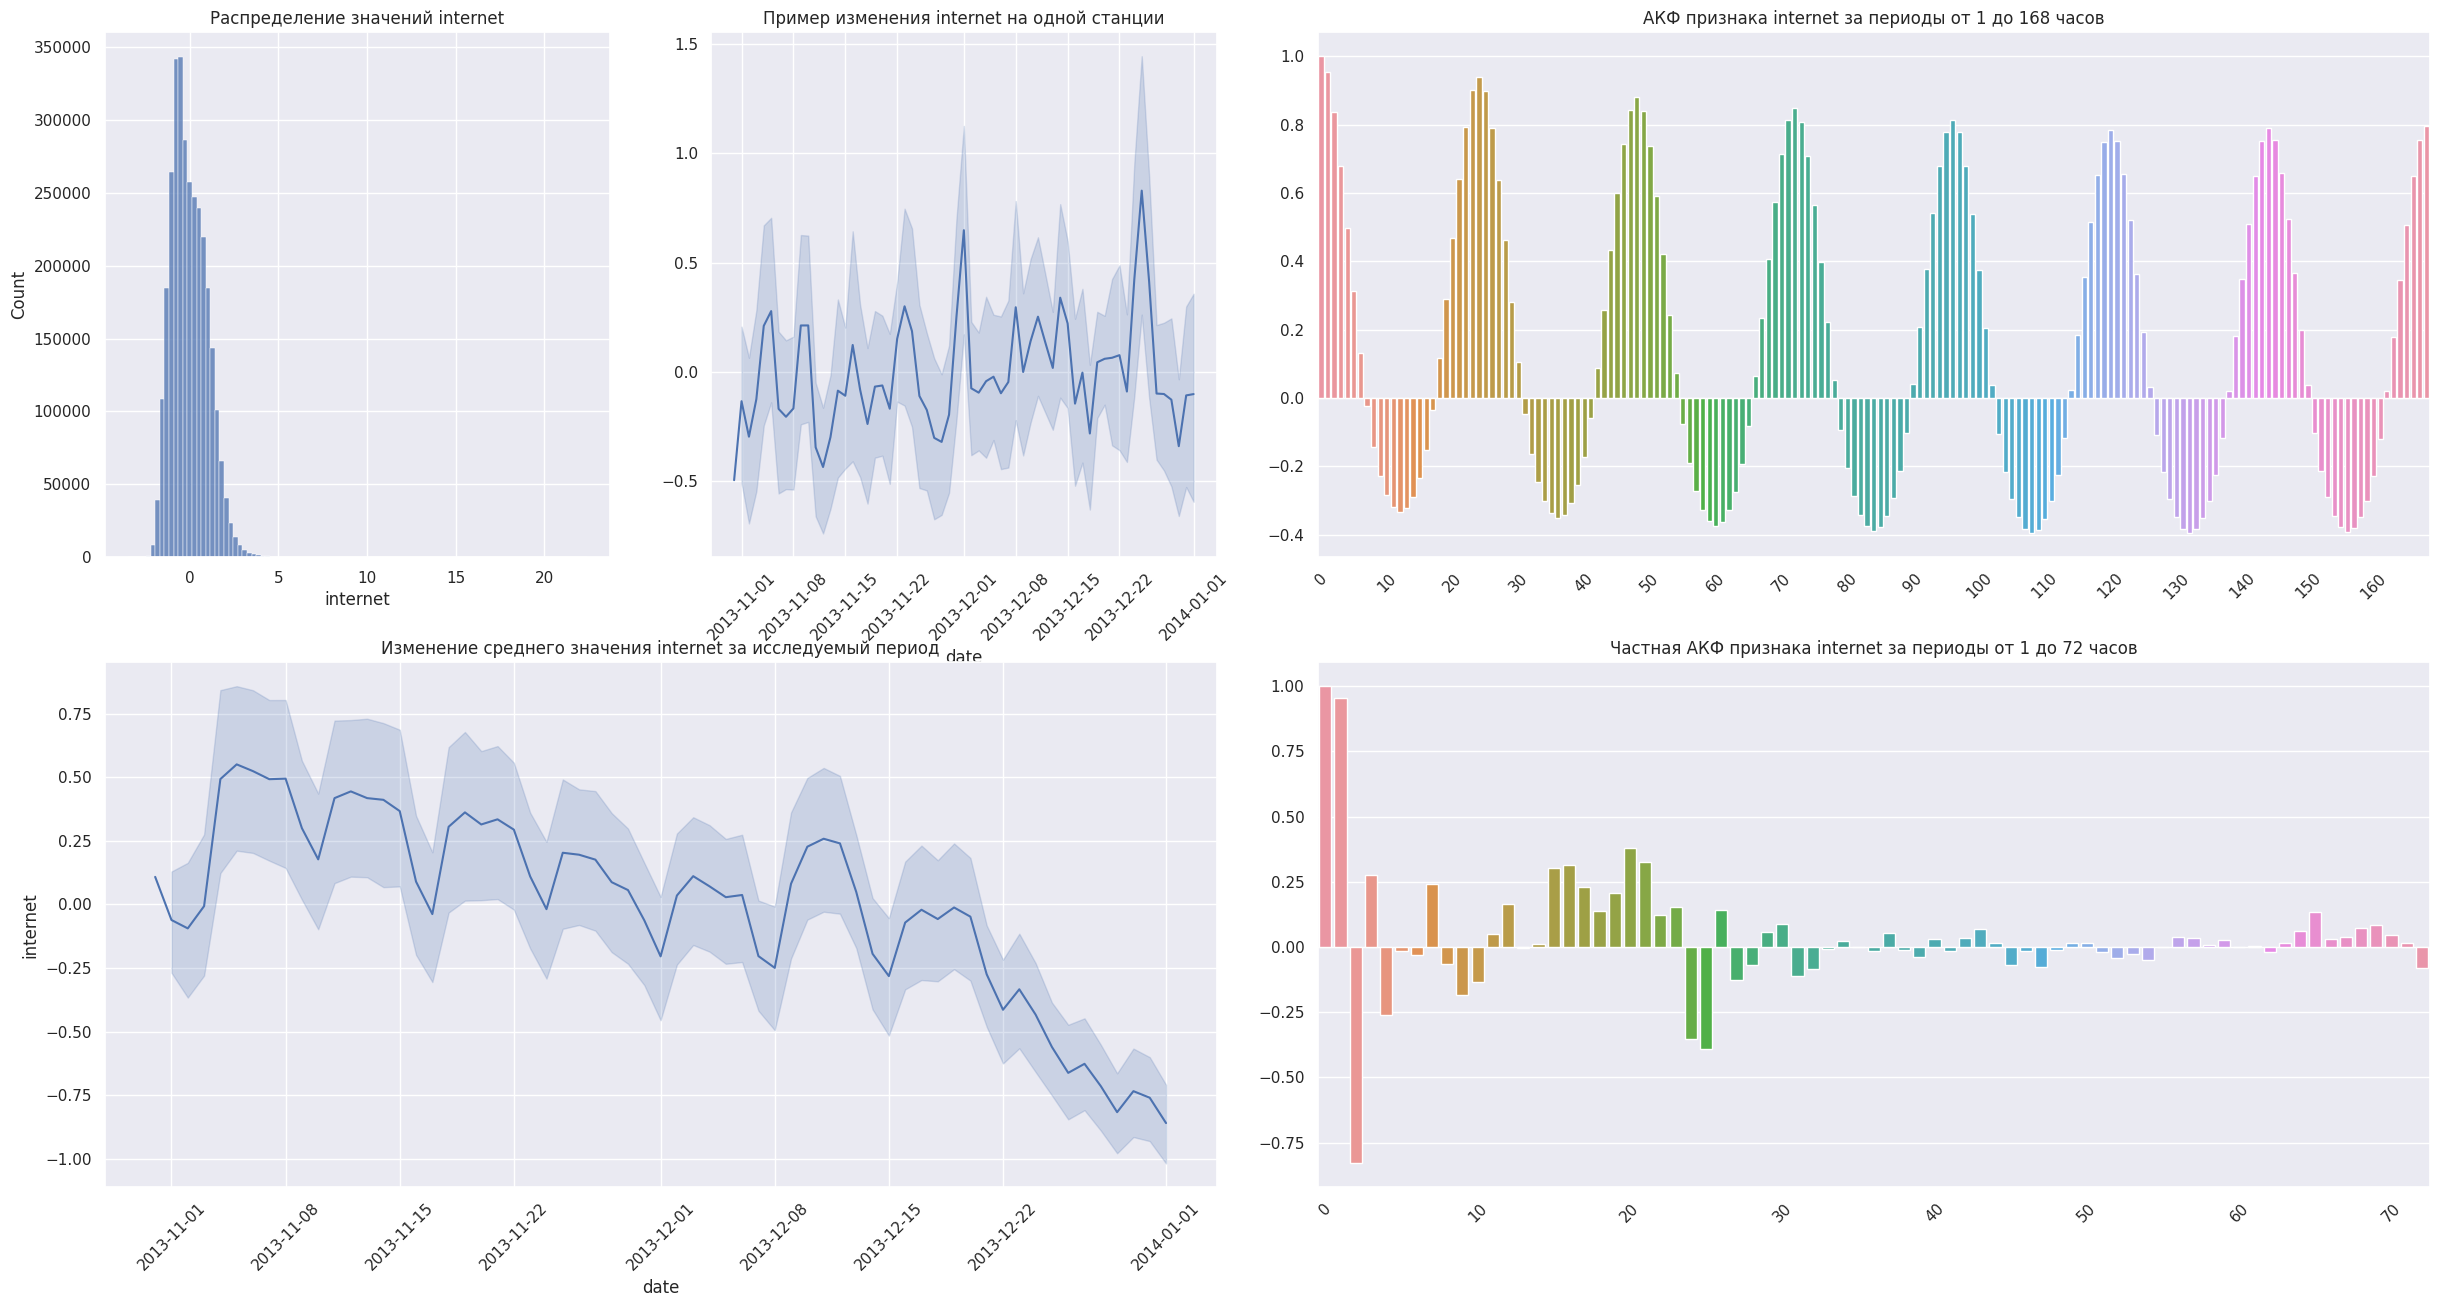

In [6]:
vis_col(df, 'internet', scaled=True)

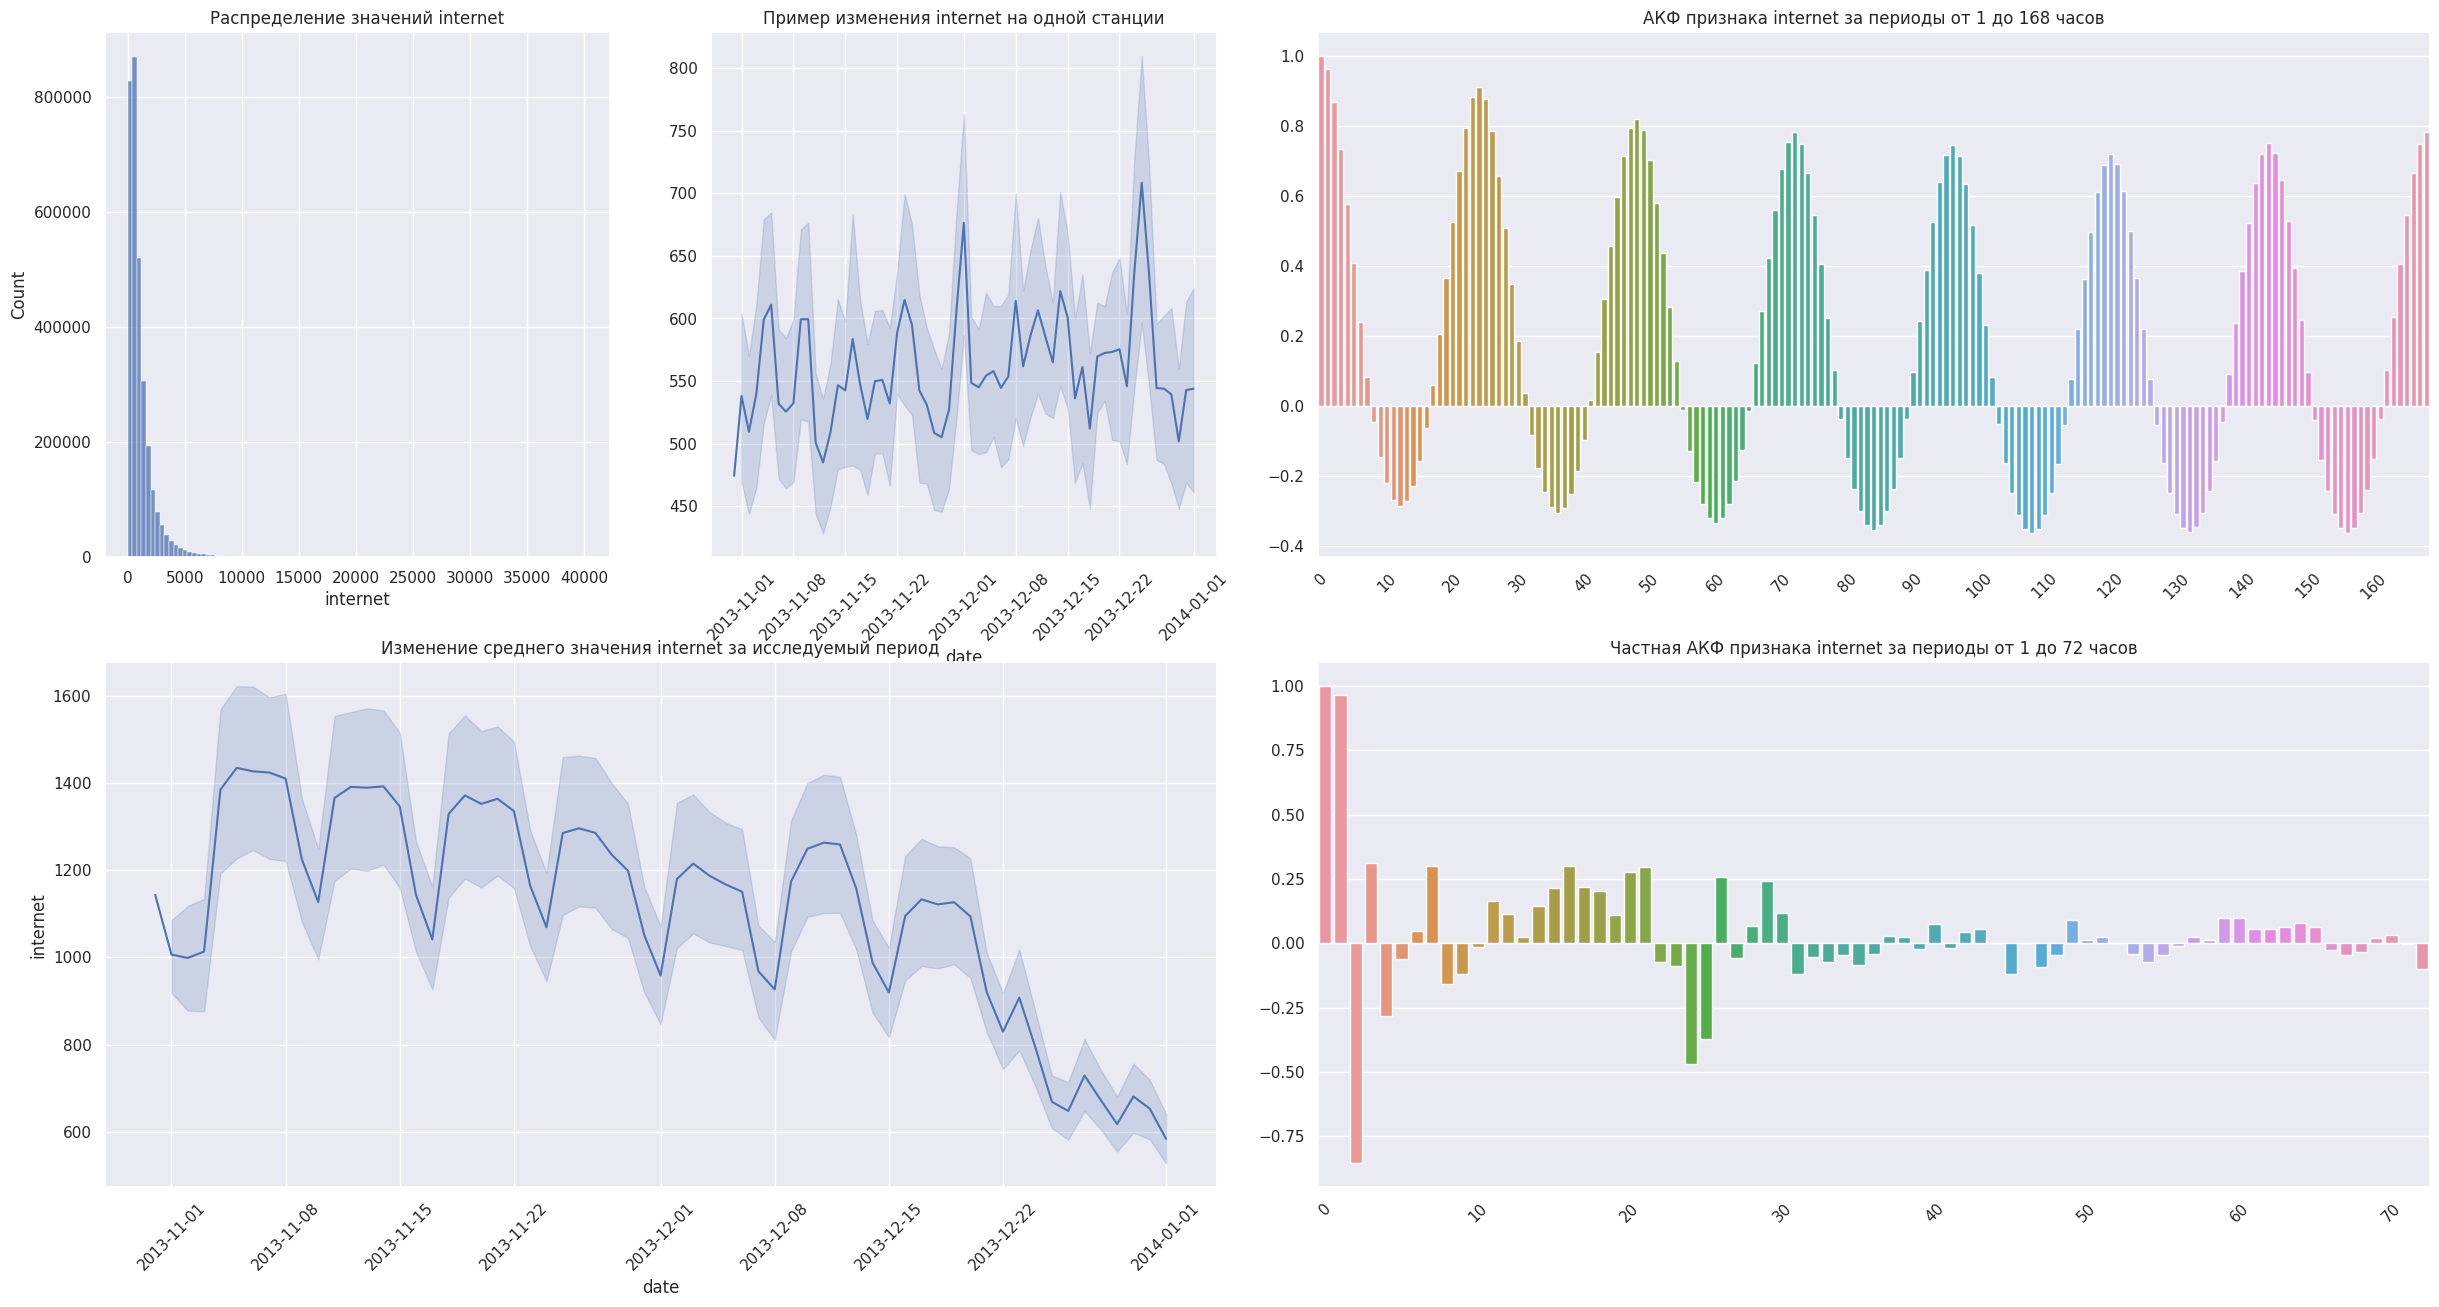

In [7]:
vis_col(df, 'internet', scaled=False)

Поскольку мы будем анализировать только значения интернет-нагрузки, ограничимся этими графиками. Однако, рекомендую отобразить другие показатели и сравнить их поведение с интернет-нагрузкой.

### Стационарность временных рядов

Сейчас посмотрим на распределение p-values, полученных при тестировании на стационарность различных временных рядов по кадой БС. В первых двух ячейках происходит вычисление p-значений для изначальных данных и данных после применения преобразования Бокса-Кокса. Затем в третьей ячейке данные стационаризируются с использованием сезонного дифференцирования, и снова рассчитываются p-значения.

*Для ускорения расчетов берем только 200 БС, можете взять больше*

In [8]:
# Проверка стационарности для изначальных данных
p_vals = []
for s in tqdm(df.square_id.unique()[:200]):
    row = df[df.square_id == s].internet
    p = sm.tsa.stattools.adfuller(row)[1]
    p_vals.append(p)

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# Проверка стационарности для данных после преобразования Бокса-Кокса
p_vals_box = []
for s in tqdm(df.square_id.unique()[:200]):
    row, lmbda = stats.boxcox(df[df.square_id == s].internet)
    p = sm.tsa.stattools.adfuller(row)[1]
    p_vals_box.append(p)


  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
# Проверка стационарности для данных после сезонного дифференцирования
p_vals_stationary = []
for s in tqdm(df.square_id.unique()[:200]):
    row, lmbda = stats.boxcox(df[df.square_id == s].internet)
    row = pd.Series(row) - pd.Series(row).shift(24)
    p = sm.tsa.stattools.adfuller(row[24:])[1]
    p_vals_stationary.append(p)

  0%|          | 0/200 [00:00<?, ?it/s]

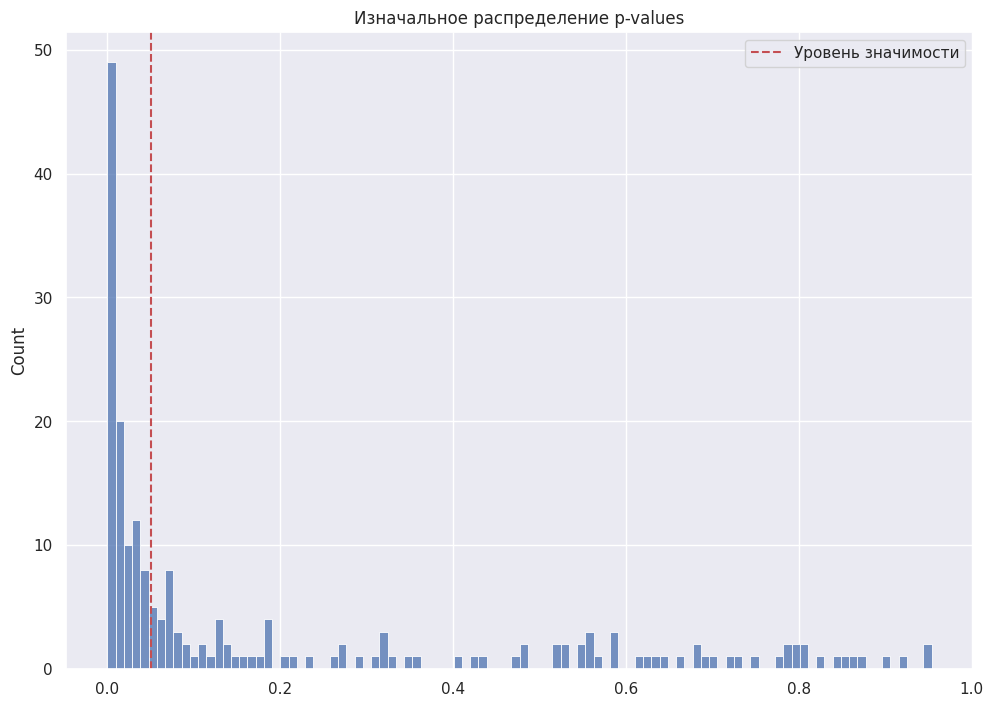

In [11]:
plt.title('Изначальное распределение p-values')
sns.histplot(p_vals, bins=100)
plt.axvline(x=0.05, color='r', linestyle='--', label='Уровень значимости')
plt.legend();

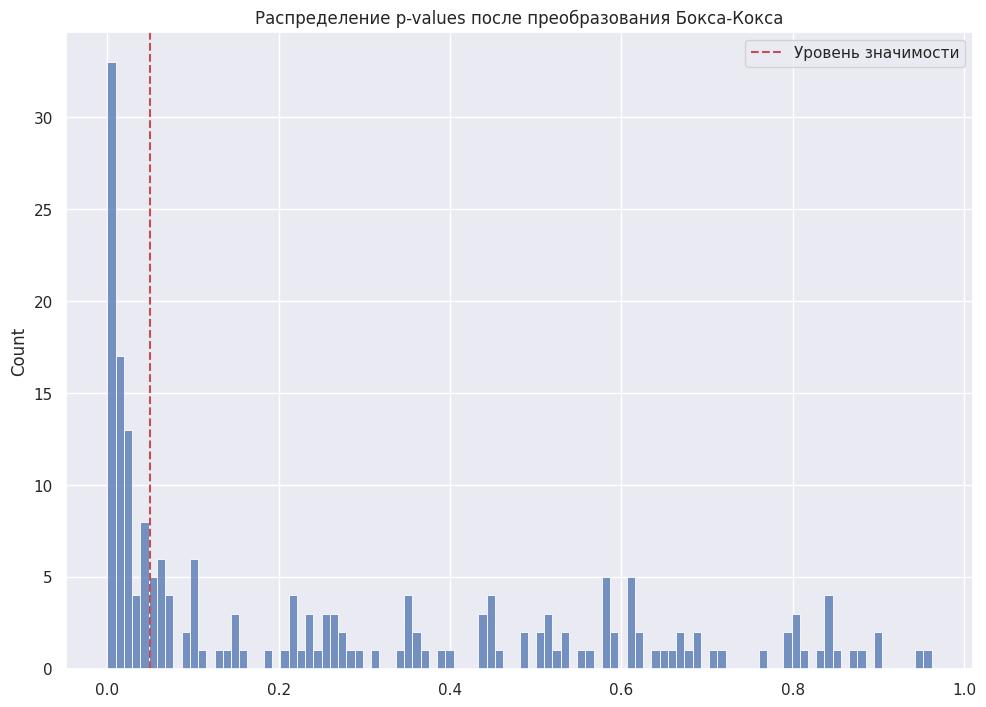

In [12]:
plt.title('Распределение p-values после преобразования Бокса-Кокса')
sns.histplot(p_vals_box, bins=100)
plt.axvline(x=0.05, color='r', linestyle='--', label='Уровень значимости')
plt.legend();

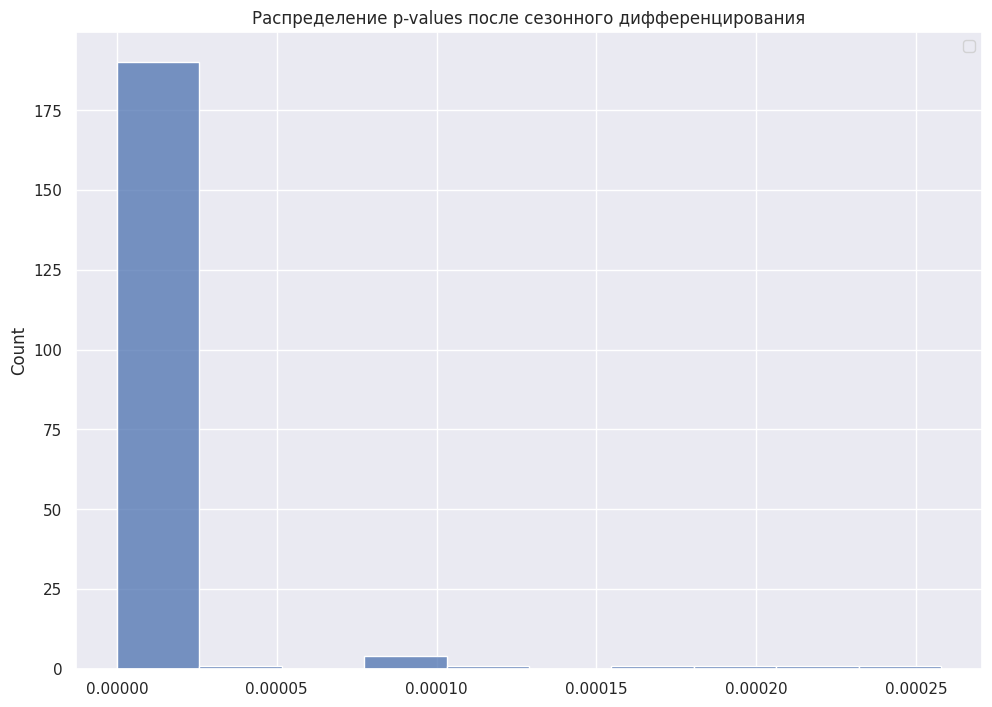

In [13]:
plt.title('Распределение p-values после сезонного дифференцирования')
sns.histplot(p_vals_stationary, bins=10)
# plt.axvline(x=0.05, color='r', linestyle='--', label='Уровень значимости')
plt.legend();